# Fitting a Hologram

This notebook shows how to load a pre-recorded hologram of a colloidal sphere
into a Feature object and analyze it with Lorenz-Mie theory. The analysis yields
the radius of the sphere, the refractive index of the sphere, and the sphere's
three-dimensional location relative to the center of the imaging plane.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2

from pylorenzmie.detection.localize import localize

from pylorenzmie.analysis import Frame

## Framework for Lorenz-Mie analysis
First, we instantiate a Frame() object. By default, Frame analyzes features with 
the standard Lorenz-Mie model for hologram formation. The model includes a description of the holographic microscope that records the images we wish to analyze. In this example, we specify that the instrument illuminates the sample with blue light at a vacuum wavelength of $\lambda$ = 0.447 μm and has a system magnification of 0.048 μm/pixel. For particles dispersed in water, the refractive index of the medium is $n_m$ = 1.340 at the imaging wavelength. These calibration constants may differ for different hardware implementations.
The commercial xSight instrument, for example, uses a system magnification of 0.120 μm/pixel.

In [12]:
configuration = dict(wavelength = 0.447,    # [um]
                     magnification = 0.048, # [um/pixel]
                     n_m = 1.34, 
                     distribution = 'radial',
                     percentpix = 0.2)

frame = Frame(**configuration)

## Read in holographic microscopy data
Next, we load the (normalized) hologram we wish to fit. In the present example, we use OpenCV to load a pre-recorded hologram that was saved as a PNG image. We convert the image to grayscale and normalize it by the mean value. This hologram was cropped from a larger image. Since we are not interested in locating the particle within the original image, we provide the model with a standard coordinate system using the coordinates() helper function. We finally can provide the normalized image data to the Feature() object for analysis.

In [13]:
# Read example image
img = cv2.imread('tutorials/image0010.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float)

## Holograms must be normalized for analysis

Frame() takes care of this automatically if the background property is set

In [14]:
frame.background = np.mean(img)

## Load the recorded image into the Frame

In [15]:
frame.image = img

## Identify features and estimate bounding boxes

Frame.data holds the automagically normalized image data need for analysis

In [16]:
centers, bboxes = localize(frame.data)
frame.bboxes = bboxes

Original hologram overlaid with particle positions and bounding boxes:

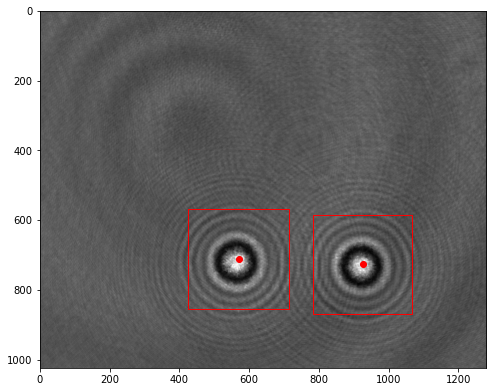

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img, cmap='gray')
ax.scatter(*centers.T, color='r')
for bbox in bboxes:
    ax.add_patch(Rectangle(*bbox, fill=False, ec='r'))

## Estimate the parameters for each particle and perform fits

In [18]:
for n, feature in enumerate(frame.features):
    particle = feature['fitter'].particle
    particle.r_p = np.array([*centers[n], 200])
    particle.n_p = 1.5
    particle.a_p = 1.

results = frame.optimize()

In [19]:
print(results)

          x_p      dx_p         y_p      dy_p         z_p      dz_p       a_p  \
0  562.426810  0.065283  720.599141  0.062045  172.286532  0.340095  2.092684   
1  920.367032  0.067255  732.434208  0.064527  170.904889  0.348315  2.055907   

       da_p       n_p      dn_p  success   npix     redchi  
0  0.002858  1.370430  0.000133     True  16704  14.608751  
1  0.002865  1.369838  0.000128     True  16017  13.880483  
